In [1]:
pip install mealpy==2.5.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 874.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mafese==0.1.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# imports

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mafese as mfse

2024-04-30 20:29:03.477432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 20:29:03.477553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 20:29:03.789926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# loading the images
train_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
test_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

# generator
def datagen(func):
  train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              horizontal_flip = True,
              vertical_flip = True,
              rotation_range = 0.5,
              width_shift_range = 0.25,
              height_shift_range = 0.25,
              shear_range = 0.2,
              zoom_range = 0.4,
              validation_split = 0.2)

  test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.0)

  test_gen_2 = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.2)

  pred_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.2)

  train_set = train_gen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = True, subset = 'training')
  test_set = test_gen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset='training')
  val_set = test_gen_2.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset='validation')
  pred_tr_set = pred_gen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset = 'training')
  return train_set, test_set, val_set, pred_tr_set

In [5]:
# model
base_model = tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False
inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics
              =["accuracy"])

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,335,746 (222.53 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [6]:
len(model.layers[1].layers)

564

In [7]:
tr_set, te_set, v_set, pr_set = datagen(tf.keras.applications.resnet_v2.preprocess_input)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 80000 images belonging to 2 classes.


In [8]:
# callback and fit
early_stopping_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True, verbose = 1),
                            tf.keras.callbacks.ReduceLROnPlateau(paitence = 1, monitor = 'val_loss', min_lr = 0.00001)]

history = model.fit(tr_set, epochs = 15, validation_data = v_set, callbacks = early_stopping_callbacks)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1714509265.500274      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714509265.601222      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6155 - loss: 0.6999

W0000 00:00:1714511038.724797      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714511266.939233      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 2080s 3s/step - accuracy: 0.6156 - loss: 0.6997 - val_accuracy: 0.8022 - val_loss: 0.4281 - learning_rate: 1.0000e-04
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1427s 2s/step - accuracy: 0.7864 - loss: 0.4538 - val_accuracy: 0.8438 - val_loss: 0.3606 - learning_rate: 1.0000e-04
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1426s 2s/step - accuracy: 0.8153 - loss: 0.4088 - val_accuracy: 0.8608 - val_loss: 0.3320 - learning_rate: 1.0000e-04
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1417s 2s/step - accuracy: 0.8280 - loss: 0.3869 - val_accuracy: 0.8696 - val_loss: 0.3140 - learning_rate: 1.0000e-04
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1416s 2s/step - accuracy: 0.8346 - loss: 0.3755 - val_accuracy: 0.8737 - val_loss: 0.3022 - learning_rate: 1.0000e-04
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1563s 2s/step - accuracy: 0.8406 - loss: 0.3616 - val_accuracy: 0.8761 - val_loss: 0.2967 - learning_rate: 1.0000e-04
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1611s 3s/step - accurac

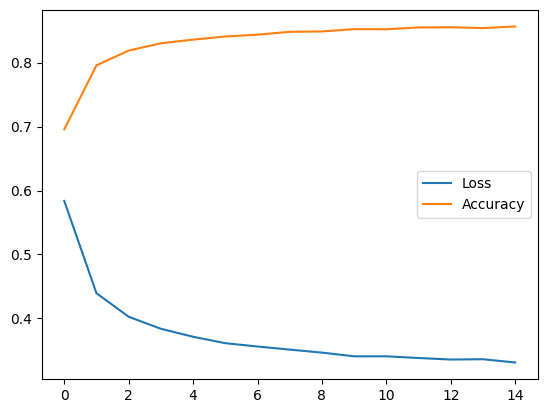

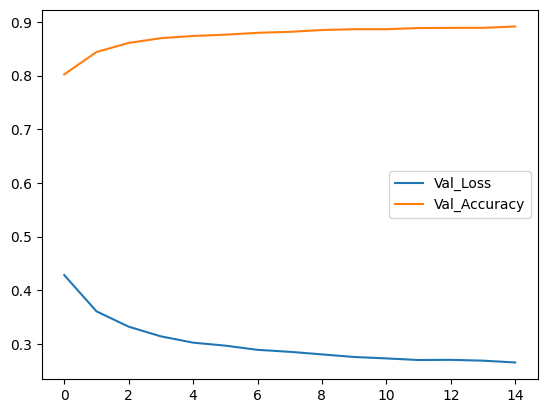

In [9]:
# loss curve

l = np.concatenate([history.history['loss']])
acc = np.concatenate([history.history['accuracy']])
lv = np.concatenate([history.history['val_loss']])
accv = np.concatenate([history.history['val_accuracy']])

plt.plot(l, label="Loss")
plt.plot(acc, label="Accuracy")
plt.legend()
plt.show()
plt.plot(lv, label="Val_Loss")
plt.plot(accv, label="Val_Accuracy")
plt.legend()
plt.show()

In [10]:
model.save("r152full_pretrain.keras")

In [11]:
# fine tune

base_model = model.layers[1]
base_model.trainable = True

fine_tune_at = 500

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3,restore_best_weights = True, verbose = 1)


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics
              =["accuracy"])

history_ft = model.fit(tr_set, epochs = 10, validation_data = te_set, callbacks = [early_stopping_callbacks])

Epoch 1/10


W0000 00:00:1714531397.456448      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8555 - loss: 0.3336

W0000 00:00:1714532685.563541      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714532885.235320      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 1558s 2s/step - accuracy: 0.8555 - loss: 0.3335 - val_accuracy: 0.9251 - val_loss: 0.1866
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1380s 2s/step - accuracy: 0.9033 - loss: 0.2355 - val_accuracy: 0.9402 - val_loss: 0.1498
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1372s 2s/step - accuracy: 0.9191 - loss: 0.1994 - val_accuracy: 0.9513 - val_loss: 0.1243
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1373s 2s/step - accuracy: 0.9287 - loss: 0.1785 - val_accuracy: 0.9545 - val_loss: 0.1155
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1366s 2s/step - accuracy: 0.9352 - loss: 0.1605 - val_accuracy: 0.9600 - val_loss: 0.1014
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1386s 2s/step - accuracy: 0.9412 - loss: 0.1477 - val_accuracy: 0.9639 - val_loss: 0.0948
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1384s 2s/step - accuracy: 0.9452 - loss: 0.1412 - val_accuracy: 0.9644 - val_loss: 0.0930
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1378s 2s/step - accuracy: 0.9493 - loss: 0.1299 - val_accurac

In [12]:
model.save("r152full_final.keras")

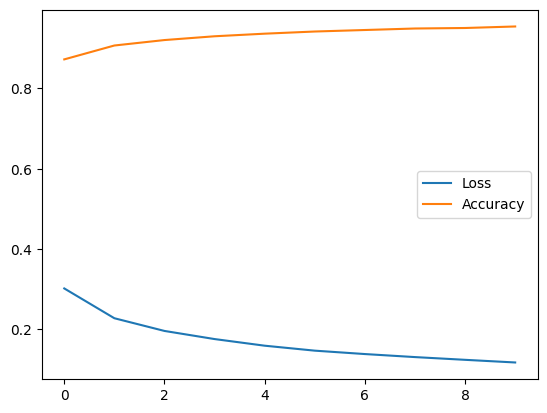

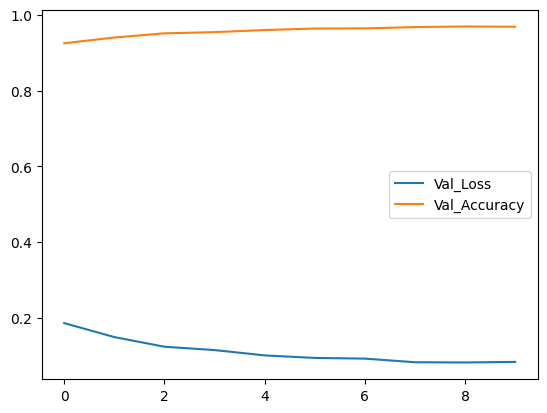

In [13]:
# loss curve

l = np.concatenate([history_ft.history['loss']])
acc = np.concatenate([history_ft.history['accuracy']])
lv = np.concatenate([history_ft.history['val_loss']])
accv = np.concatenate([history_ft.history['val_accuracy']])

plt.plot(l, label="Loss")
plt.plot(acc, label="Accuracy")
plt.legend()
plt.show()
plt.plot(lv, label="Val_Loss")
plt.plot(accv, label="Val_Accuracy")
plt.legend()
plt.show()

In [14]:
model.evaluate(te_set)

157/157 ━━━━━━━━━━━━━━━━━━━━ 105s 667ms/step - accuracy: 0.9752 - loss: 0.0687


[0.08277685195207596, 0.9693999886512756]